In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文 If you do not understand Chinese, just remove this line and the next line
plt.rcParams['axes.unicode_minus']=False    #显示中文后,显示负号 
# plt.rcParams['text.usetex'] = True          # use latex to display. However, this will make every display take a long time

from scipy.optimize import curve_fit
import os
path='./figs/'
os.makedirs(path,exist_ok=True) 

# 规范化不确定度

In [2]:
def string_result(x,dx,latex=False):
    # return a string "x ± dx" with scientific format, latex determine weather to use latex code.
    if dx == 0:
        return f'{x:.3e} wiht dx is absolute zero'
    order_x=int(np.floor(np.log10(abs(x))))
    order_dx=int(np.floor(np.log10(abs(dx))))
    value_x=x/10**order_x
    value_dx=dx/10**order_dx
    delord=order_x-order_dx
    # print(delord)
    if delord>=0:
        two_number=0
        # print(value_dx)
        if (value_dx<2):
            two_number=1
        
        value_dx=value_dx*10**(-delord)
        # order_x=log(x)/log(10)
        delord+=two_number
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"
        up = order_x
    else :
        delord = abs(delord)
        value_x = value_x*10**(-delord)
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"
        up = order_dx

    if latex:
        return(f'$( {value_x_show}\\pm{value_dx_show} )\\times 10^{{{up}}}$')
    else:
        return(f'({value_x_show} ± {value_dx_show} )×10^{up}')

# 曲线拟合

In [3]:
def from_fitting_to_plot(xdata,ydata,yerror=[],
                         model = lambda x,k,b:k*x+b,
                         report = True,latex = True,
                         **opt):
    '''
    report: whether to print the main result
    latex: whether to report the result by latex  
    opt contains setting of one plot. but no setting of the whole fig. The fig object will be returned and you can set it yourself.
            figsize with default None: the figsize of the plot
            dot_label with default None: the label of orginate data dots
            dot_color with default 'r': the color of orginate data dots
            plot_label with default None: the label of fitting data lines
            plot_color with default 'b': the color of fitting data lines
            markersize with default 6: the size of orginate data dots
            capsize with default 2*markersize: the capsize of orginate data dots,refer to plt.errorbar
            capthick with default None: the captihick of orginate data dots,refer to plt.errorbar
            plotnumber with default 1000: the number of points in plot
    
    Return :
        result of curvefit
        matplotlib object fig and ax    
    '''
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    with_error = (len(yerror)!=0)
    # print(with_error)
    yerror = np.array(yerror)
    from scipy.optimize import curve_fit
    if with_error:
        params,covmatrix = curve_fit(model,xdata,ydata,sigma=yerror)
    else:
        params,covmatrix = curve_fit(model,xdata,ydata)
    std = np.sqrt(np.diag(covmatrix))
    yfit = model(xdata,*params)
    if with_error:
        ymean = np.average(ydata,weights=1/yerror**2)
    else:
        ymean = ydata.mean()
    tss = np.sum((ydata - ymean)**2)
    rss = np.sum((ydata - yfit)**2)
    r_squared = 1 - (rss / tss)
    if report:
        for i in range(params.shape[0]):
            print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=latex)}')
        print(f"决定系数R^2为:{r_squared}")

    figsize = opt['figsize'] if 'figsize' in opt else None
    dot_label = opt['dot_label'] if 'dot_label' in opt else None
    dot_color = opt['dot_color'] if 'dot_color' in opt else 'r'
    plot_label = opt['plot_label'] if 'plot_label' in opt else None
    plot_color = opt['plot_color'] if 'plot_color' in opt else 'b'
    markersize = opt['markersize'] if 'markersize' in opt else 6
    capsize= opt['capsize'] if 'capsize' in opt else 2*markersize
    capthick = opt['capthick'] if 'capthick' in opt else None
    plotnumber = opt['plotnumber'] if 'plotnumber' in opt else 1000

    fig, ax = plt.subplots(figsize=figsize)
    if with_error:
        ax.errorbar(xdata, ydata, yerr=yerror/2, fmt='o',
                    color = dot_color, markersize=markersize,
                    capsize=capsize, capthick=capthick,
                    label=dot_label)
    else:
        ax.errorbar(xdata, ydata, fmt='o',
                    color = dot_color, markersize=markersize,
                    capsize=capsize, capthick=capthick,
                    label=dot_label)

    max_value = np.max(xdata)
    min_value = np.min(xdata)
    linspace_xdata = np.linspace(min_value, max_value, plotnumber)
    #If it were an acceptable function for NumPy, it would be much more convenient. Here, we consider the general case.
    linspace_ydata=[]
    for v in linspace_xdata:
        linspace_ydata.append(model(v,*params))
    linspace_ydata=np.array(linspace_ydata)

    ax.plot(linspace_xdata, linspace_ydata, label=plot_label, color=plot_color)
    if bool(dot_label) or bool(plot_label):
        ax.legend()

    return (params,std,covmatrix,r_squared),(fig,ax)


## Example

In [4]:
np.random.seed(0)

### linear fit

The default model is linear model

第0个参数的结果为:$( 1.86\pm0.05 )\times 10^{0}$
第1个参数的结果为:$( 1.8\pm0.3 )\times 10^{0}$
决定系数R^2为:0.9647825387004532


((array([1.85883775, 1.84637052]),
  array([0.05126077, 0.29746036]),
  array([[ 0.00262767, -0.01313834],
         [-0.01313834,  0.08848267]]),
  0.9647825387004532),
 (<Figure size 640x480 with 1 Axes>, <Axes: >))

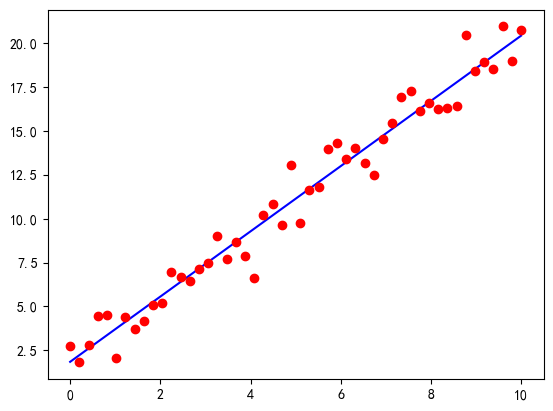

In [5]:
xdata = np.linspace(0, 10, 50)
ydata = 2 * xdata + 1 + np.random.normal(0, 1, 50)
from_fitting_to_plot(xdata,ydata)

There are many things displayed here, because the return value of the function contians too many things. You can add `None` in a line to avoid them.

第0个参数的结果为:$( 2.12\pm0.04 )\times 10^{0}$
第1个参数的结果为:$( 4\pm2 )\times 10^{-1}$
决定系数R^2为:0.984066544976185


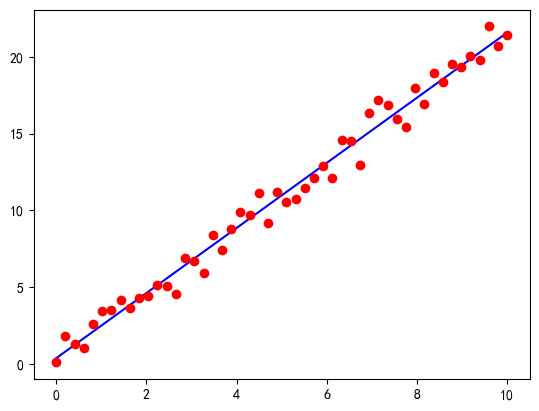

In [6]:
xdata = np.linspace(0, 10, 50)
ydata = 2 * xdata + 1 + np.random.normal(0, 1, 50)
from_fitting_to_plot(xdata,ydata)
None

fig with error on y

第0个参数的结果为:$( 1.87\pm0.03 )\times 10^{0}$
第1个参数的结果为:$( 2.2\pm0.2 )\times 10^{0}$
决定系数R^2为:0.9690466625214254


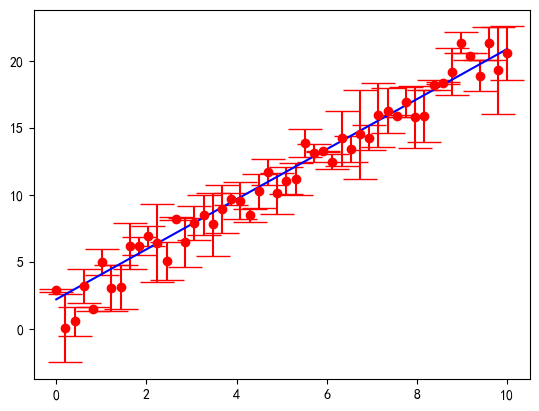

In [7]:
xdata = np.linspace(0, 10, 50)
ydata = 2 * xdata + 1 + np.random.normal(0, 1, 50)
yerror = np.abs(np.random.normal(0,3,50))
from_fitting_to_plot(xdata,ydata,yerror)
None

fit with you own model

第0个参数的结果为:$( 2\pm4 )\times 10^{0}$
第1个参数的结果为:$( 1.5\pm1.7 )\times 10^{0}$
第2个参数的结果为:$( 1.01\pm0.16 )\times 10^{0}$
决定系数R^2为:0.9427765761301626


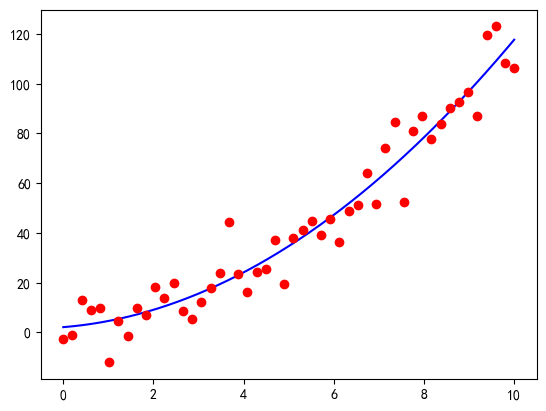

In [8]:
def my_model(x,a,b,c):
    return a + b*x + c*x**2
xdata = np.linspace(0, 10, 50)
ydata = xdata**2 + 2 * xdata + 1 + np.random.normal(0, 10, 50)
from_fitting_to_plot(xdata,ydata,model=my_model)
None

What about `opts`

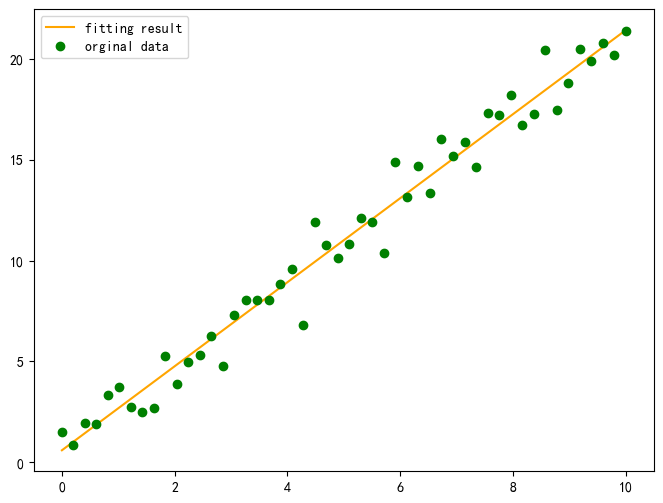

In [9]:
xdata = np.linspace(0, 10, 50)
ydata = 2 * xdata + 1 + np.random.normal(0, 1, 50)
_,b = from_fitting_to_plot(xdata,ydata,
                           figsize = (8,6),
                           dot_label='orginal data',plot_label='fitting result',
                           dot_color='g',plot_color='orange',
                           report=False)
None

If you want to set title, xlim, label and so on about matplotlib

第0个参数的结果为:$( 2.01\pm0.05 )\times 10^{0}$
第1个参数的结果为:$( 7\pm3 )\times 10^{-1}$
决定系数R^2为:0.9761183054326898


Text(0, 0.5, 'y value')

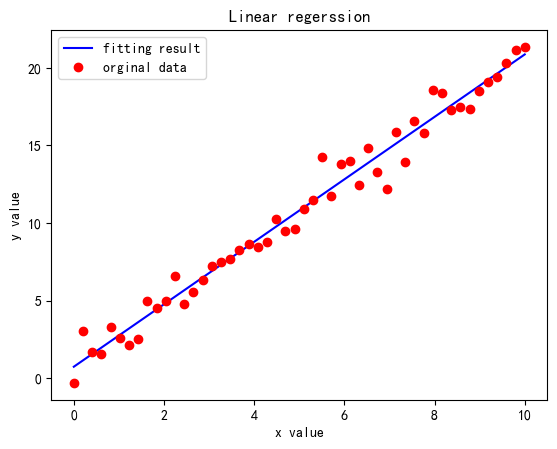

In [10]:
xdata = np.linspace(0, 10, 50)
ydata = 2 * xdata + 1 + np.random.normal(0, 1, 50)
_,b = from_fitting_to_plot(xdata,ydata,
                           dot_label='orginal data',plot_label='fitting result')
fig,ax = b
ax.set_title('Linear regerssion')
ax.set_xlabel('x value')
ax.set_ylabel('y value')

how to save the picture?

In [11]:
fig.tight_layout()
fig.savefig(path+'name.pdf')